In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage.filters as filters
from scipy.interpolate import interp1d as spline
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Hypothesis: CA1 performs probabilistic inference on the stimulus to infer current place in position x morph space

The posterior probability of the true stimulus, $S$ , given the animals observation, $\hat{S}$ , is $P(S|\hat{S}) \propto P(\hat{S}|S)P(S)$ (Bayes Rule),
where $P(\hat{S}|S)$ is the likelihood of an observation given the stimulus (aka noisy sensory estimate of the stimulus), and $P(S)$ is the prior over the stimuli.
One straighforward way of estimating the stimulus from $P(S|\hat{S})$ is to choose the most likely value of $S$. This is called *Maximum a Posteriori* ($MAP$) inference

$$ MAP(\hat{S}) = max_{S} P(S|\hat{S})$$

We will assume that the network is in fact performing $MAP$ inference. To get an idea of what types of remapping we should see if this is true, we will change the prior and see what happens to the $MAP$ estimate.

In a dynamic model, we could assume that the network instead samples from the posterior distribution. We should get largely the same result that we have in the static model we will explore here. 

In [2]:
# preliminaries - make general some purpose functions
gaussian = lambda mu,sigma,x: np.exp(-(mu-x)**2/sigma**2)
unif = lambda mu, sigma, x: 1*(np.abs(x-mu)<=sigma/2)
G = lambda _g,_f: np.convolve(np.convolve(_g,_f,mode='same'),_f,mode='same')

def gaussian_dens(mu,sigma,x):
    v = gaussian(mu,sigma,x)
    return v/v.sum()

def mult_and_norm(dens1,dens2):
    post = dens1*dens2
    return post/post.sum()


### Weber-Fechner's Law

Ernst Weber (1795–1878) first developed a quantitative relationship between individual's perception of the values of a stimulus and the true values of the stimulus. In short, he found that the perceived change in a stimulus is proportional to the initial stimulus. Weber also incorporated the idea of a just noticable difference, the smallest change in a stimulus that can be perceived. We can express this relationship as the following equation
$$ dS \propto S $$

In the 1860 Gustav Fechner further this idea into "Weber contrast"

$$ dp \propto \frac{dS}{S} $$

where $dp$ is the change in perception.

From this equation it is straightforward to derive "(Weber)-Fechner's Law"

$$ p \propto \ln \frac{S}{S_0} $$


This relationship has been successfully used to describe a number of phenomena in visual perception. 

In our experiments, since the animals experience interleaved visual virtual environments this provides a framework for understanding the perceptual change of the mouse across trials. You can convince yourself that this log-transform may account for your own perception of our stimuli by looking at the example stimuli in Fig 1a. The tracks near the higher end of the morph axis (.75-1.3) appear more similar than the tracks near the lower end of the morph axis (-.3-.25). 

Below, we show how this log-transform affects the morph values. In the figures from the main text, you can see that this log-transform accounts for some subtleties in the neural activity such the location of the discontinuity in the Rare Morph Similarity Fraction plots and place cell maps and the bunching of representations around the $S=1$ but not the $S=0$ representation.


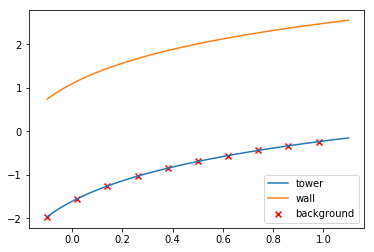

In [3]:
# first, showing that the log-transform for each aspect of the stimulus is the same

_theta = np.linspace(-.1,1.1,num=1000) # possible morph values for a single aspect of the stimulus

# actual values of stimuli shown to mice in native space
f0_t,f1_t = .2, .8 # fraction green S=0, fraction blue S=1
f0_b,f1_b = .2,.8 # fraction black S=0, fraction white S=1
f0_w, f1_w = 3, 12 # actual frequencies of sine waves on wall for S= 0 and S=1 stimuli

# plotting log of stimulus values
f,ax = plt.subplots()
ax.plot(_theta,np.log(f0_t*(1-_theta)+f1_t*_theta), label = 'tower')
ax.scatter(_theta[::100], np.log(f0_b*(1-_theta[::100])+f1_b*_theta[::100]), marker='x',color='red',label = 'background')
ax.plot(_theta, np.log(f0_w*(1-_theta)+f1_w*_theta), label = 'wall')

ax.legend()

Note that these curves are all equivalent with just a scalar offset. This is due to the fact that the intervals of the stimuli are all proportional 

##### {f0_t,f1_t} = {f0_b, f0_t} = {1/12\*f0_w,1/12\* f1_w} 

and $ \log(cx) = \log(c) + \log(x)$ 

This means we can simply apply the same log transform to the sum

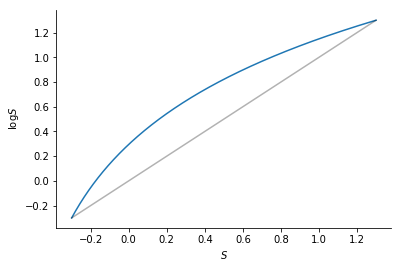

In [4]:
# arbitrarily choosing the frequency of the wall cues for the log correction
_theta_log = np.log(f0_w*(1-_theta)+f1_w*_theta)
# scaling this to be between -.3 and 1.6 like the morph values
theta_log = (_theta_log-np.amin(_theta_log))/(np.amax(_theta_log)-np.amin(_theta_log))*1.6 - .3 
theta_log[0],theta_log[-1]=-.3,1.3 # hard code the edges to correct float errors


theta = np.linspace(-.3,1.3,num=1000)
# splines for going between the two spaces
morph_2_logstim = spline(theta,theta_log)
logstim_2_morph = spline(theta_log,theta)

f,ax = plt.subplots()
ax.plot(theta,theta_log)
ax.set_xlabel("$S$")
ax.set_ylabel(" $ \log S$")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(theta,theta, color='black', alpha=.3)

# $MAP$ inference under Rare Morph prior

In [5]:
# functions for calculation of distributions and plotting

def convert_prior_to_log(prior,samp = np.linspace(-.3,1.3,num=1000)):
    '''convert a prior distribution in stimulus space to logspace for proper sampling
    Input: prior - arbitrary distribution assumed to be sampled in the range(-.3,1.3)
    Returns: log_dens - log space density for use with run_posterior_inference
            (f,ax) - figure and axis handles
    '''
   
    # normalize to ensure prior is a proper distribution
    prior = np.convolve(prior,gaussian(.5,.1,samp),mode='same')
    prior/=prior.sum()
    
    # go to cummulative distribution so that conversion maintains density
    cum_prior = np.cumsum(prior)
    cum_prior[0],cum_prior[-1] = 0,1 # correct for float errors
    cum_spline = spline(samp,cum_prior) # fit a linear interpolation spline so that we can arbitrarily sample
    log_cum_spline = spline(morph_2_logstim(samp),cum_prior)
    log_cum = log_cum_spline(samp) # sample cummulative distribution in log space
    log_sampling_spline = spline(cum_prior,morph_2_logstim(samp))  # create transposed spline for sampling values according to their probability
    
    f,ax = plt.subplots(1,2)
    for a in range(2):
        ax[a].spines['right'].set_visible(False)
        ax[a].spines['top'].set_visible(False)
        
    ax[0].plot(samp,cum_prior,label='morph space',color='black')
    ax[0].plot(morph_2_logstim(samp),cum_prior,label='log space',color='red')
    ax[0].legend()
    ax[0].set_ylabel('$F(S)$')
    ax[0].set_xlabel('$S$')
    
    ax[1].plot(samp,prior,color='black')
    #convert cumulative density back to density
    log_dens = log_cum[1:]-log_cum[:-1]
    log_dens = np.append(log_dens,log_dens[-1])
    log_dens /=log_dens.sum()
    ax[1].plot(morph_2_logstim(samp),log_dens,color='red')
    ax[1].set_ylabel('$P(S)$')
    ax[1].set_xlabel('$S$')
    ax[1].set_yticks([])
    
    return log_dens, (f,ax)



def run_posterior_inference(p_theta,samp=np.linspace(-.3,1.3,num=1000),color='black'):
    '''function runs probabilistic inference and makes a few helpful plots
    Inputs: p_theta - the stimulus prior in log-space sampled at the values of previously defined theta
    Returns: theta_hat - MAP estimate at each value of samp
            theta_hat_var - variance of posterior at each value of samp
            example S_hat value fig, ax handles
            MAP estimate fig ax handles'''
    
    
    ### RUN SOME DEMOS OF WHAT THE INFERENCE PROCESS LOOKS LIKE AT DIFFERENT STIMULUS VALUES
    
    # likelihood - zero centered gaussian with fixed variance in log space
    p_s_theta = gaussian_dens(morph_2_logstim(-.15),.3,samp)

    # posterior - multiply likelihood and posterior and normalize to be a valid distribution
    p_theta_s = mult_and_norm(p_s_theta,p_theta)

    f_post_demo,ax_post_demo = plt.subplots(2,5,figsize=[15,6])
    f_post_demo.subplots_adjust(hspace=.5)
    ax_post_demo[0,0].plot(samp,p_theta,label='prior',color='red')
    ax_post_demo[0,0].plot(samp,p_s_theta,label='likelihood',alpha=.4,color='blue')
    ax_post_demo[0,0].plot(samp,p_theta_s,label='posterior',color='green')
    
    ax_post_demo[0,0].spines['right'].set_visible(False)
    ax_post_demo[0,0].spines['top'].set_visible(False)
    ax_post_demo[0,0].set_yticks([])
    ax_post_demo[0,0].set_ylabel('$P$')
    ax_post_demo[0,0].set_xlabel('$S$')
    ax_post_demo[0,0].set_title("$\hat{S} =$ -.15")

    # repeat above for a few other stimulus values
    for i,s in enumerate(morph_2_logstim(np.array([0,.15,.3,.45,.6,.75,.9,1.05,1.2 ]))):
        
        # likelihood 
        p_s_theta = gaussian_dens(s,.2,samp)

        # posterior 
        p_theta_s = mult_and_norm(p_s_theta,p_theta)

        if i <4: 
            row,col=0,i
        else: 
            row,col=1,i-4-1
        
        ax_post_demo[row,col+1].plot(samp,p_theta,label='prior',color='red')
        ax_post_demo[row,col+1].plot(samp,p_s_theta,label='likelihood',alpha=.4,color='blue')
        ax_post_demo[row,col+1].plot(samp,p_theta_s,label='posterior',color='green')
        ax_post_demo[row,col+1].spines['right'].set_visible(False)
        ax_post_demo[row,col+1].spines['top'].set_visible(False)
        ax_post_demo[row,col+1].set_yticks([])
        ax_post_demo[row,col+1].set_title("$\hat{S} =$ %.2f" % logstim_2_morph(s) )
#         ax_post_demo[i+1].set_ylim([0,.05])

    ax_post_demo[-1,-1].legend()
   

    ### CALCULATE MAP at range of stimulus values
    theta_hat=[] # keep track of MAP estimate
    theta_hat_var = [] # variance of posterior
    for i,s in enumerate(samp): # sample log-spaced values
        p_s_theta = gaussian_dens(s,.3,samp) # likelihood
        p_theta_s = mult_and_norm(p_s_theta,p_theta) # posterior
        theta_hat.append(samp[np.argmax(p_theta_s)]) # MAP estimate
        mu = (samp*p_theta_s).sum() # expected value
        theta_hat_var.append((((samp-mu)**2)*p_theta_s).sum()) # variance
        


    ## PLOT MAP ESTIMATE
    f_MAP,ax_MAP = plt.subplots(1,2,figsize=[10,3])
    f_MAP.subplots_adjust(wspace=.5)
    ax_MAP[0].spines['right'].set_visible(False)
    ax_MAP[0].spines['top'].set_visible(False)
    ax_MAP[0].scatter(logstim_2_morph(theta),logstim_2_morph(np.array(theta_hat)),color=color)
    ax_MAP[0].set_ylim([1.2,-.2])
    ax_MAP[0].set_ylabel('$S_{MAP}$')
    ax_MAP[0].set_xlabel('$S$')
    
    ax_MAP[1].spines['right'].set_visible(False)
    ax_MAP[1].spines['top'].set_visible(False)
    ax_MAP[1].scatter(logstim_2_morph(theta),np.array(theta_hat),color=color)
    ax_MAP[1].set_ylim([1.3,-0.3])
    ax_MAP[1].set_ylabel('log $S_{MAP}$')
    ax_MAP[1].set_xlabel('$S$')
    
    return np.array(theta_hat),np.array(theta_hat_var),(f_post_demo,ax_post_demo),(f_MAP,ax_MAP)





## Prior

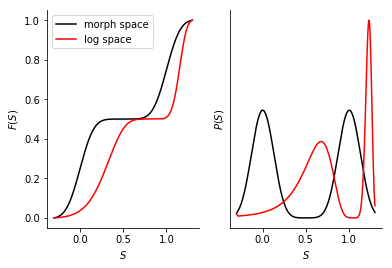

In [6]:
# setup Rare Morph prior 
samp = np.linspace(-.3,1.3,num=1000)
f = unif(.5,.2,samp)
rare_prior = G(unif(0,.2,samp),f) + G(unif(1,.2,samp),f) + 1E-2
rare_log_dens, fig = convert_prior_to_log(rare_prior)


## Rare Morph Inference

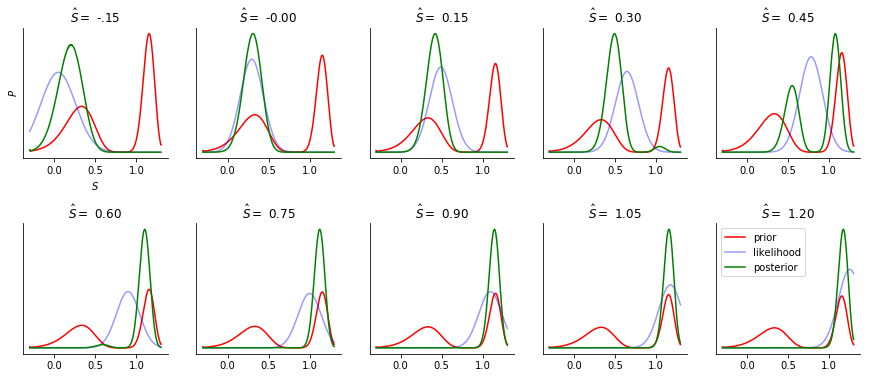

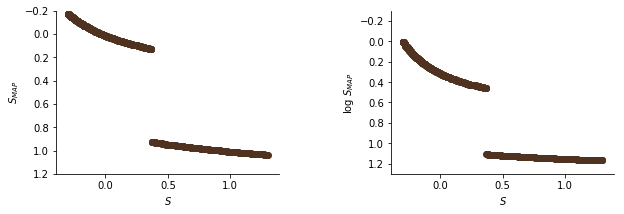

In [7]:
# RUN INFERENCE

rare_p_shat, rare_p_shat_var,(f_post_demo,ax_post_demo),(f_MAP,ax_MAP) = run_posterior_inference(rare_log_dens,color=plt.cm.copper(.25))


## Frequent Morph Prior 

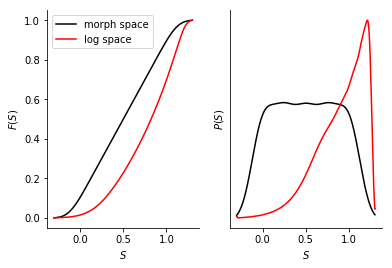

In [8]:
# setup prior in logspace

freq_prior = G(unif(0,.2,samp),f) +G(unif(.25,.2,samp),f) +G(unif(.5,.2,samp),f) +G(unif(.75,.2,samp),f) + G(unif(1,.2,samp),f) + 1E-2
freq_log_dens, fig = convert_prior_to_log(freq_prior)


## Frequent Morph Inference

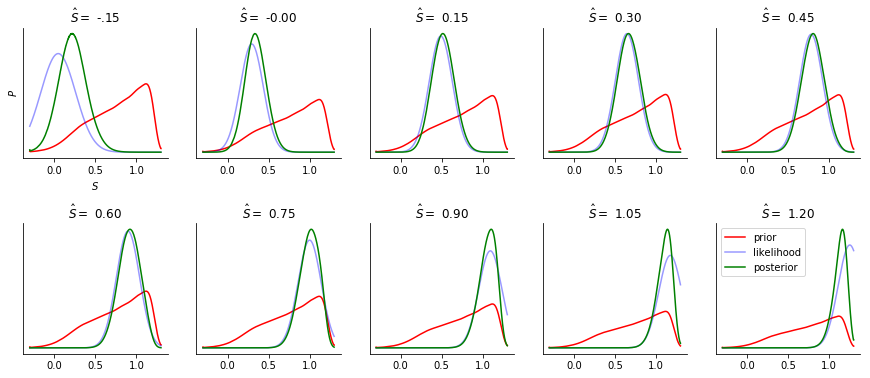

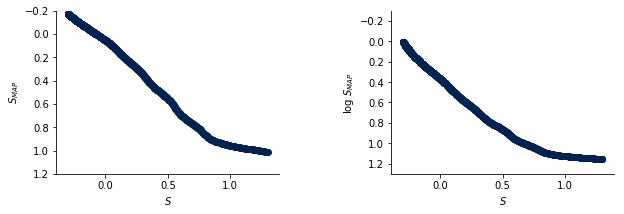

In [9]:
freq_p_shat,freq_p_shat_var,(f_post_demo,ax_post_demo),(f_MAP,ax_MAP) = run_posterior_inference(freq_log_dens,color=plt.cm.cividis(0.))
